# Importación de paquetes iniciales

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import logging
import os

# Configuración del sistema de excepciones y logs
Se van a almacenar en una carpeta en el root según las indicaciones de la prueba

In [93]:
# Crear un directorio de registros si no existe
log_dir="logs"
os.makedirs(log_dir, exist_ok=True)

# Configurar la configuración de registro
log_file=os.path.join(log_dir, "application.log")
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
file_handler=logging.FileHandler(log_file)
file_handler.setLevel(logging.ERROR)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logging.getLogger().addHandler(file_handler)

In [94]:
# Define la ruta del archivo
ruta_archivo="datasets/flights.csv"

# Lee el archivo CSV en un DataFrame de pandas, por velocidad se hace con una muestra de 400.000 filas
df=pd.read_csv(ruta_archivo, delimiter="|",nrows=400000)

# Muestra las primeras filas del DataFrame
df.head()

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,AIRLINENAME,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,...,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE
0,54548800,20020101,WN,Southwest Airlines Co.: WN,N103@@,1425,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1648.0,4.0,1655,1652.0,-3.0,90.0,87.0,F,False,580 miles
1,55872300,20020101,CO,Continental Air Lines Inc.: CO,N83872,150,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1419.0,16.0,1426,1435.0,9.0,116.0,119.0,False,F,744 miles
2,54388800,20020101,WN,Southwest Airlines Co.: WN,N334@@,249,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1618.0,2.0,1500,1620.0,80.0,105.0,102.0,F,False,718 miles
3,54486500,20020101,WN,Southwest Airlines Co.: WN,N699@@,902,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1947.0,1.0,1950,1948.0,-2.0,85.0,83.0,0,0,487 miles
4,55878700,20020103,CO,Continental Air Lines Inc.: CO,N58606,234,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1742.0,5.0,1750,1747.0,-3.0,115.0,114.0,F,False,744 miles


In [95]:
df.shape

(400000, 31)

Se comprueba que el dataset tiene más de un millon de filas como se pide en la prueba y que carga todas las filas del csv.

# EDA

In [96]:
# Se revisa el tipo de cada columna para identificar si están correctas o se debe hacer algun ajuste
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   TRANSACTIONID      400000 non-null  int64  
 1   FLIGHTDATE         400000 non-null  int64  
 2   AIRLINECODE        400000 non-null  object 
 3   AIRLINENAME        400000 non-null  object 
 4   TAILNUM            346875 non-null  object 
 5   FLIGHTNUM          400000 non-null  int64  
 6   ORIGINAIRPORTCODE  400000 non-null  object 
 7   ORIGAIRPORTNAME    400000 non-null  object 
 8   ORIGINCITYNAME     400000 non-null  object 
 9   ORIGINSTATE        394597 non-null  object 
 10  ORIGINSTATENAME    394597 non-null  object 
 11  DESTAIRPORTCODE    400000 non-null  object 
 12  DESTAIRPORTNAME    400000 non-null  object 
 13  DESTCITYNAME       400000 non-null  object 
 14  DESTSTATE          397440 non-null  object 
 15  DESTSTATENAME      397440 non-null  object 
 16  CR

Se identifica que la columna FlightDate deberia ser una fecha, la distancia debería ser un número, Cancelled y Diverted deben tener valor booleano.

In [97]:
try:
    #Se convierte la fecha
    df['FLIGHTDATE']=pd.to_datetime(df['FLIGHTDATE'], format='%Y%m%d')

    #Se ajusta la columna Distance
    df['DISTANCE']=df['DISTANCE'].str.replace(' miles', '')
    df['DISTANCE']=pd.to_numeric(df['DISTANCE'],errors='raise')
    
    df['DEPDELAY']=pd.to_timedelta(df['DEPDELAY'], unit='min',errors='ignore')
    df['TAXIOUT']=pd.to_timedelta(df['TAXIOUT'], unit='min',errors='ignore')
    df['TAXIIN']=pd.to_timedelta(df['TAXIIN'], unit='min',errors='ignore')
    df['ARRDELAY']=pd.to_timedelta(df['ARRDELAY'], unit='min',errors='ignore')
    df['CRSELAPSEDTIME']=pd.to_timedelta(df['CRSELAPSEDTIME'], unit='min',errors='ignore')
    df['ACTUALELAPSEDTIME']=pd.to_timedelta(df['ACTUALELAPSEDTIME'], unit='min',errors='ignore')
    
    #df['TAXIOUT']=df['TAXIOUT'].dt.total_seconds()/60

    #Se ajustan las columnas booleanas
    df['CANCELLED']=df['CANCELLED'].map({'0': False, '1': True, 'True': True, 'False': False, 'T': True, 'F': False})
    df['DIVERTED']=df['DIVERTED'].map({'0': False, '1': True, 'True': True, 'False': False, 'T': True, 'F': False})

except Exception as e:
    logging.exception(f"Se ha presentado una excepcion: {e}")


C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arrays\timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arrays\timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Aunque no es del todo necesario capturas los errores en este punto pues es muy manual este proceso se deja para probar el sistema logging, si se corre dos veces este bloque se dispara una excepcion por aplicarle .str. a la columna distance que ya es numerica.

Para seguir con las columnas que tiene formato de hora vemos que dos de ellas tienen formato int64 y el resto float64, quiere decir que las int no tienen valores nulos mientras que las otras si, se verifica esto para proceder a su transformació.

In [98]:
# Convertir columnas a formato fecha hora
columnas_hora = ['CRSDEPTIME', 'DEPTIME', 'WHEELSOFF', 'WHEELSON', 'CRSARRTIME','ARRTIME']
for columna in columnas_hora:
    if df[columna].isnull().sum()==0:
        df[columna]=df[columna].astype(str).str.zfill(4)
        df[columna]=pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
        df[columna]=df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
        df[columna]=pd.to_datetime(df[columna],errors='coerce')


In [99]:
# Se verifican los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   TRANSACTIONID      400000 non-null  int64          
 1   FLIGHTDATE         400000 non-null  datetime64[ns] 
 2   AIRLINECODE        400000 non-null  object         
 3   AIRLINENAME        400000 non-null  object         
 4   TAILNUM            346875 non-null  object         
 5   FLIGHTNUM          400000 non-null  int64          
 6   ORIGINAIRPORTCODE  400000 non-null  object         
 7   ORIGAIRPORTNAME    400000 non-null  object         
 8   ORIGINCITYNAME     400000 non-null  object         
 9   ORIGINSTATE        394597 non-null  object         
 10  ORIGINSTATENAME    394597 non-null  object         
 11  DESTAIRPORTCODE    400000 non-null  object         
 12  DESTAIRPORTNAME    400000 non-null  object         
 13  DESTCITYNAME       400000 non

## Datos faltantes

In [100]:
# Análisis de valores nulos
null_values=df.isnull().sum() / len(df) * 100
print("Porcentaje de valores nulos por columna:")
print(null_values)

Porcentaje de valores nulos por columna:
TRANSACTIONID         0.00000
FLIGHTDATE            0.00000
AIRLINECODE           0.00000
AIRLINENAME           0.00000
TAILNUM              13.28125
FLIGHTNUM             0.00000
ORIGINAIRPORTCODE     0.00000
ORIGAIRPORTNAME       0.00000
ORIGINCITYNAME        0.00000
ORIGINSTATE           1.35075
ORIGINSTATENAME       1.35075
DESTAIRPORTCODE       0.00000
DESTAIRPORTNAME       0.00000
DESTCITYNAME          0.00000
DESTSTATE             0.64000
DESTSTATENAME         0.64000
CRSDEPTIME            0.00050
DEPTIME               2.39000
DEPDELAY              2.39000
TAXIOUT              15.24200
WHEELSOFF            15.24650
WHEELSON             15.38675
TAXIIN               15.37775
CRSARRTIME            0.00150
ARRTIME               2.56400
ARRDELAY              2.64000
CRSELAPSEDTIME        0.04100
ACTUALELAPSEDTIME     2.64000
CANCELLED             0.00000
DIVERTED              0.00000
DISTANCE              0.00000
dtype: float64


El porcentaje de datos faltantes en algunos campos va desde 0.9% hasta 15% en otros, en este punto del proceso no se considera eliminar estos registros, se procede a explorar los datos con el fin de decidir si descartar las columnas con alto porcentaje o si utilizar alguna técnica para completar la información faltante.

C:\Users\alejo\AppData\Local\Temp\ipykernel_25400\3462987559.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df.corr()


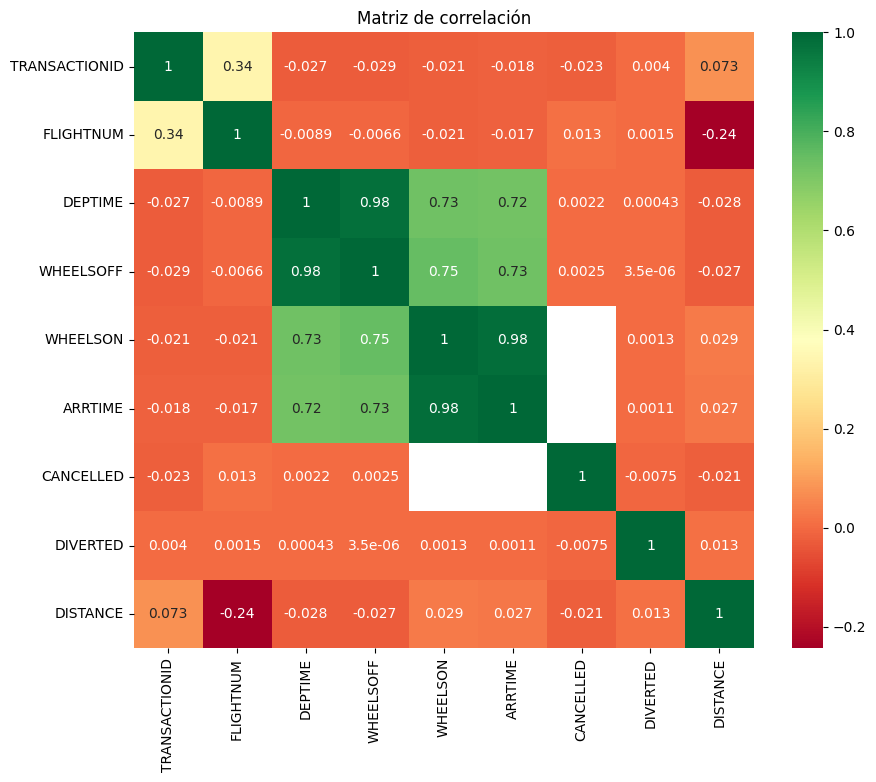

In [101]:
# Matriz de correlación
correlation_matrix=df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn")
plt.title("Matriz de correlación")
plt.show()

Aunque la matriz de correlación se utiliza más para modelos numéricos y preparar la data para modelos predictivos en este punto nos puede dar una pista si al descartar una columna podríamos afectar otra.

Empezando por la columna que más datos le faltan (TAILNUM) se analiza si es necesario rellenar o no estos valores, esta columna corresponde a la identificación única de cada avión y sin más datos que nos permitan identificar a cada aeronave es imposible conseguir este valor; también se puede apreciar en la matriz que este valor no tiene gran influencia sobre las otras columnas, por lo tanto se dejaran los valores nulos y no se eliminaran estos registros.

Ahora se procede a revisar ORIGINSTATE y ORIGINSTATENAME, como tenemos el código del aeropuerto podemos buscarlo en los aeropuertos de destino y así encontrar la información faltante

In [102]:
# Crear un diccionario de mapeo entre DESTAIRPORTCODE y DESTSTATE
codigos = df.set_index('DESTAIRPORTCODE')['DESTSTATE'].to_dict()

# Rellenar los valores faltantes en ORIGINSTATE usando el diccionario de mapeo
df['ORIGINSTATE'] = df['ORIGINSTATE'].fillna(df['ORIGINAIRPORTCODE'].map(codigos))

Como esta estrategia no redujo el número de datos faltantes se procede a conectarse a una API gratuita que retorna la información del aeropuerto basado en el código único

In [103]:
def airport_info(airport_code):

	url = "https://airport-info.p.rapidapi.com/airport"

	querystring = {"iata":airport_code}

	headers = {
		"X-RapidAPI-Key": "6f294ed6f0mshd9fbb45d9c15ffbp112336jsn9ed08e8c22a6",
		"X-RapidAPI-Host": "airport-info.p.rapidapi.com"
	}
	try:
		response = requests.get(url, headers=headers, params=querystring)

	except Exception as e:
		logging.exception(f"Se ha presentado una excepcion al consultar la API: {e}")
		return
	
	print(response.json())

	return response.json()

In [104]:
# Filtrar el diccionario para obtener solo las claves con valor NaN
codigos_faltantes = {key: value for key, value in codigos.items() if pd.isna(value)}

codigos_completos={}

for key in codigos_faltantes:
    codigos_completos[key]=airport_info(key)['state']

{'id': 5548, 'iata': 'OKC', 'icao': 'KOKC', 'name': 'Will Rogers World Airport', 'location': 'Oklahoma City, Oklahoma, United States', 'street_number': '7100', 'street': 'Terminal Drive', 'city': 'Oklahoma City', 'county': '', 'state': 'Oklahoma', 'country_iso': 'US', 'country': 'United States', 'postal_code': '73159', 'phone': '+1 405-316-3200', 'latitude': 35.393055, 'longitude': -97.600555, 'uct': -300, 'website': 'http://www.flyokc.com/'}
{'id': 7645, 'iata': 'TUL', 'icao': 'KTUL', 'name': 'Tulsa International Airport', 'location': 'Tulsa, Oklahoma, United States', 'street_number': '7777', 'street': 'East Apache Street', 'city': 'Tulsa', 'county': 'Tulsa County', 'state': 'Oklahoma', 'country_iso': 'US', 'country': 'United States', 'postal_code': '74115', 'phone': '+1 918-838-5000', 'latitude': 36.198776, 'longitude': -95.883865, 'uct': -300, 'website': 'http://www.tulsaairports.com/'}
{'id': 3125, 'iata': 'ICT', 'icao': 'KICT', 'name': 'Wichita Dwight D. Eisenhower National Airpor

Como ya se tiene un diccionario con el nombre del estado para cada aeropuerto faltante se agregan los datos al dataframe

In [105]:
df['ORIGINSTATENAME'] = df['ORIGINSTATENAME'].fillna(df['ORIGINAIRPORTCODE'].map(codigos_completos))
df['DESTSTATENAME'] = df['DESTSTATENAME'].fillna(df['DESTAIRPORTCODE'].map(codigos_completos))

Ahora se completan las columnas ORIGINSTATE Y DESTSTATE, para esto se utiliza otro dataset pequeño con todos los estados y su abreviatura

In [106]:
# Se carga el dataset
df_estados = pd.read_csv("datasets/us_states.tsv", sep="\t")

# Se extraen los estados y su abreviatura
abreviaturas = df_estados.set_index('name')['state'].to_dict()

# Se elimina el dataset para liberar memoria
del df_estados

In [107]:
df['ORIGINSTATE'] = df['ORIGINSTATE'].fillna(df['ORIGINSTATENAME'].map(abreviaturas))
df['DESTSTATE'] = df['DESTSTATE'].fillna(df['DESTSTATENAME'].map(abreviaturas))

### Columnas de tiempo

Se comprueban si aún quedan valores nulos

In [108]:
# Análisis de valores nulos
null_values=df.isnull().sum() / len(df) * 100
print("Porcentaje de valores nulos por columna:")
print(null_values)


Porcentaje de valores nulos por columna:
TRANSACTIONID         0.00000
FLIGHTDATE            0.00000
AIRLINECODE           0.00000
AIRLINENAME           0.00000
TAILNUM              13.28125
FLIGHTNUM             0.00000
ORIGINAIRPORTCODE     0.00000
ORIGAIRPORTNAME       0.00000
ORIGINCITYNAME        0.00000
ORIGINSTATE           0.01525
ORIGINSTATENAME       0.01525
DESTAIRPORTCODE       0.00000
DESTAIRPORTNAME       0.00000
DESTCITYNAME          0.00000
DESTSTATE             0.00000
DESTSTATENAME         0.00000
CRSDEPTIME            0.00050
DEPTIME               2.39000
DEPDELAY              2.39000
TAXIOUT              15.24200
WHEELSOFF            15.24650
WHEELSON             15.38675
TAXIIN               15.37775
CRSARRTIME            0.00150
ARRTIME               2.56400
ARRDELAY              2.64000
CRSELAPSEDTIME        0.04100
ACTUALELAPSEDTIME     2.64000
CANCELLED             0.00000
DIVERTED              0.00000
DISTANCE              0.00000
dtype: float64


Para los valores nulos que aún quedan se van a insertan los valores aproximados, por ejemplo hora de despegue programada y si la real es nula se pondrá la programada para poder rellenar los espacios, de todas formas como se vio al inicio estos valores solo corresponden al 2% y no presentan una cantidad estadisticamente considerable

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   TRANSACTIONID      400000 non-null  int64          
 1   FLIGHTDATE         400000 non-null  datetime64[ns] 
 2   AIRLINECODE        400000 non-null  object         
 3   AIRLINENAME        400000 non-null  object         
 4   TAILNUM            346875 non-null  object         
 5   FLIGHTNUM          400000 non-null  int64          
 6   ORIGINAIRPORTCODE  400000 non-null  object         
 7   ORIGAIRPORTNAME    400000 non-null  object         
 8   ORIGINCITYNAME     400000 non-null  object         
 9   ORIGINSTATE        399939 non-null  object         
 10  ORIGINSTATENAME    399939 non-null  object         
 11  DESTAIRPORTCODE    400000 non-null  object         
 12  DESTAIRPORTNAME    400000 non-null  object         
 13  DESTCITYNAME       400000 non

In [110]:
# Convertir columnas a formato fecha hora
columnas_hora = ['DEPTIME']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna]=df[columna].fillna(df['CRSDEPTIME'])
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df.loc[(df[columna].isnull()) & (df['DEPDELAY'].isnull()),columna]=df['CRSDEPTIME']
    df.loc[(df[columna].isnull()) & (df['DEPDELAY'].notnull()),columna]=df['CRSDEPTIME']+df['DEPDELAY']

columnas_hora = ['ARRTIME']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df.loc[(df[columna].isnull()) & (df['ARRDELAY'].isnull()),columna]=df['CRSARRTIME']
    df.loc[(df[columna].isnull()) & (df['ARRDELAY'].notnull()),columna]=df['CRSARRTIME']+df['ARRDELAY']


columnas_hora = ['WHEELSOFF']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df.loc[df[columna].isnull(),columna]=df['DEPTIME']+df['TAXIOUT']

columnas_hora = ['WHEELSON']
for columna in columnas_hora:
    df[columna]=df[columna].astype('Int64').astype(str)
    df[columna] = df[columna].astype(str).str.zfill(4)
    df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time
    df[columna] = df['FLIGHTDATE'].dt.strftime("%Y-%m-%d") + ' ' + df[columna].apply(str)
    df[columna] = pd.to_datetime(df[columna], errors='coerce')
    df.loc[df[columna].isnull(),columna]=df['ARRTIME']-df['TAXIIN']

df['DEPDELAY']=df['DEPDELAY'].dt.total_seconds()/60
df['TAXIOUT']=df['TAXIOUT'].dt.total_seconds()/60
df['TAXIIN']=df['TAXIIN'].dt.total_seconds()/60
df['ARRDELAY']=df['ARRDELAY'].dt.total_seconds()/60
df['CRSELAPSEDTIME']=df['CRSELAPSEDTIME'].dt.total_seconds()/60
df['ACTUALELAPSEDTIME']=df['ACTUALELAPSEDTIME'].dt.total_seconds()/60



Se corrigen las fechas de llegada para aquellos aviones que salen un día y llegan al siguiente.

In [111]:
def arreglar_fecha(row):
    if row['WHEELSOFF']<row['CRSDEPTIME']:
        row['WHEELSOFF']=row['WHEELSOFF']+pd.to_timedelta(1, unit='day',errors='ignore')
        row['WHEELSON']=row['WHEELSON']+pd.to_timedelta(1, unit='day',errors='ignore')
        row['CRSARRTIME']=row['CRSARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        row['ARRTIME']=row['ARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        return row
    elif row['WHEELSON']<row['WHEELSOFF']:
        row['WHEELSON']=row['WHEELSON']+pd.to_timedelta(1, unit='day',errors='ignore')
        row['CRSARRTIME']=row['CRSARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        row['ARRTIME']=row['ARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        return row
    elif row['ARRTIME']<row['WHEELSON']:
        row['CRSARRTIME']=row['CRSARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        row['ARRTIME']=row['ARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        return row
    elif row['ARRTIME']<row['WHEELSOFF']:
        row['ARRTIME']=row['ARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        return row
    elif row['CRSARRTIME']<row['WHEELSOFF']:
        row['CRSARRTIME']=row['CRSARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')
        return row
    elif row['ARRTIME']<row['DEPTIME']:
        row['ARRTIME']=row['ARRTIME']+pd.to_timedelta(1, unit='day',errors='ignore')

    
    return row   

In [112]:
df=df.apply(lambda row: arreglar_fecha(row),axis=1)

Ya con las fechas ajustadas se procede a llenar los vacios en las columnas ACTUALELAPSEDTIME y CRSELAPSEDTIME 

In [113]:
df.loc[df['CRSELAPSEDTIME'].isnull(),'CRSELAPSEDTIME']=pd.to_timedelta(df['CRSARRTIME']-df['CRSDEPTIME'], unit='min',errors='ignore').dt.total_seconds()/60
df.loc[df['ACTUALELAPSEDTIME'].isnull(),'ACTUALELAPSEDTIME']=pd.to_timedelta(df['ARRTIME']-df['DEPTIME'], unit='min',errors='ignore').dt.total_seconds()/60

In [114]:
df=df.replace('',np.nan)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   TRANSACTIONID      400000 non-null  int64         
 1   FLIGHTDATE         400000 non-null  datetime64[ns]
 2   AIRLINECODE        400000 non-null  object        
 3   AIRLINENAME        400000 non-null  object        
 4   TAILNUM            346875 non-null  object        
 5   FLIGHTNUM          400000 non-null  int64         
 6   ORIGINAIRPORTCODE  400000 non-null  object        
 7   ORIGAIRPORTNAME    400000 non-null  object        
 8   ORIGINCITYNAME     400000 non-null  object        
 9   ORIGINSTATE        399939 non-null  object        
 10  ORIGINSTATENAME    399939 non-null  object        
 11  DESTAIRPORTCODE    400000 non-null  object        
 12  DESTAIRPORTNAME    400000 non-null  object        
 13  DESTCITYNAME       400000 non-null  object  

Se revisa ahora si quedaron vuelos con duración negativa, es posible si los datos originales están corruptos

In [116]:
# Análisis de valores negativos
df.loc[(df['ACTUALELAPSEDTIME'] < 0) | (df['CRSELAPSEDTIME'] < 0),'ACTUALELAPSEDTIME'].sum()

0.0

Todas las duraciones de los vuelos quedaron bien, sin embargo, con fines demostrativos se realiza un análisis de datos atípicos respecto a la duración y distancia de los para determinar si es necesarios eliminar algunos valores

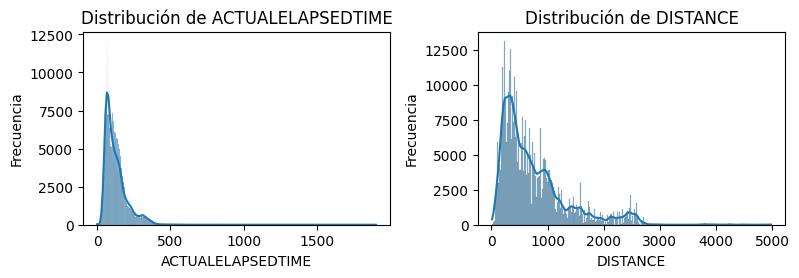

In [117]:
# Gráficas de distribución de columnas numéricas
plt.figure(figsize=(12, 10))
for i, columna in enumerate(['ACTUALELAPSEDTIME', 'DISTANCE'], 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=columna, kde=True)
    plt.title(f"Distribución de {columna}")
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [118]:
# Análisis de valores atípicos
atipicos=pd.DataFrame(columns=["Columna", "Valor atípico"])

# Para identificar los valores atipicos se utiliza el método del rango intercuartil, si conocieramos mejor el contexto
# se podría escoger otro método como la media movil u otro método
for columna in ['ACTUALELAPSEDTIME', 'DISTANCE']:
    q1=df[columna].quantile(0.25)
    q3=df[columna].quantile(0.75)
    iqr=q3 - q1
    limite_inferior=q1 - 1.5 * iqr
    limite_superior=q3 + 1.5 * iqr

    columna_atipica=df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    atipicos=pd.concat([atipicos,columna_atipica[[columna]]])

# Se eliminan los valores atípicos
df= df[~df.index.isin(atipicos.index)]

print("Valores atípicos:")
print(atipicos)

Valores atípicos:
       Columna Valor atípico  ACTUALELAPSEDTIME  DISTANCE
537        NaN           NaN              291.0       NaN
1315       NaN           NaN             1430.0       NaN
1351       NaN           NaN              325.0       NaN
1603       NaN           NaN              310.0       NaN
1840       NaN           NaN              292.0       NaN
...        ...           ...                ...       ...
399977     NaN           NaN                NaN    2125.0
399982     NaN           NaN                NaN    1964.0
399984     NaN           NaN                NaN    2677.0
399995     NaN           NaN                NaN    2496.0
399998     NaN           NaN                NaN    2378.0

[44695 rows x 4 columns]


Efectivamente los datos ya tienen una mejor distribución pero como se aclaró anteriormente esto se hace con fines demostrativos, en un caso real se debería tener el contexto de la información para entender estos valores atípicos

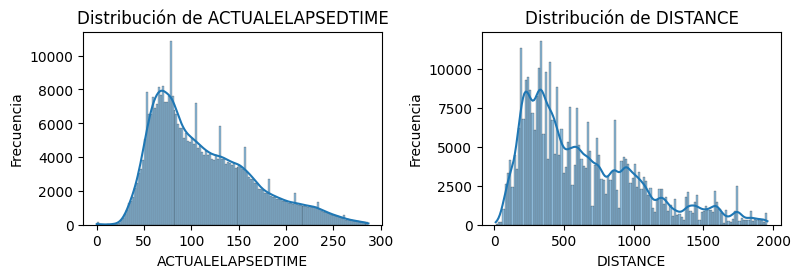

In [119]:
# Gráficas de distribución de columnas numéricas
plt.figure(figsize=(12, 10))
for i, columna in enumerate(['ACTUALELAPSEDTIME', 'DISTANCE'], 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=columna, kde=True)
    plt.title(f"Distribución de {columna}")
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Con esto termina el proceso de limpieza del dataset para proceder con la carga y diseño de la BD relacional